In [1]:
import dill as pickle
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from dataset import ImageDS, BorderPredictionDS
from architectures import CNNBase, BorderPredictionNet
from utils import my_collate, denorm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# class Testset(Dataset):    
    
#     def __init__(self, filename: str, mean: float, std: float):
        
#         self.filename = Path(filename)
#         self.mean = mean
#         self.std = std
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((mean,), (std,))
#         ])
#         with open(self.filename, "rb") as f:
#             self.data = pickle.load(f)
        
#         self.denorm = transforms.Compose([
#             transforms.Normalize((-1 * self.mean / self.std), (1.0 / self.std)),
#             transforms.Lambda(lambda x_: torch.clamp(x_ * 255, 0, 255))
#         ])   
        
#     def __len__(self):
#         return len(self.data["input_arrays"])

#     def __getitem__(self, idx):
        
#         input_array = self.data["input_arrays"][idx]
#         known_array = self.data["known_arrays"][idx]
               
#         input_array = self.transform(input_array).squeeze()
#         known_array = torch.tensor(known_array)
        
#         ar = torch.stack([input_array, known_array], dim=0).float()
        
#         return ar
    
#     def denormalize(self, x: torch.tensor):
#         return self.denorm(x)

In [4]:
class Testset(Dataset):    
    
    def __init__(self, filename: str, mean: float, std: float):
        
        self.filename = Path(filename)
        self.ds_mean = mean
        self.ds_std = std
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        with open(self.filename, "rb") as f:
            self.data = pickle.load(f)
            
        self.get_mask_vals(avg_border_size = 12)
        
        self.ds_val_zero = - self.ds_mean / self.ds_std
        
        self.denorm = transforms.Compose([
            transforms.Normalize((-1 * self.ds_mean / self.ds_std), (1.0 / self.ds_std)),
            transforms.Lambda(lambda x_: torch.clamp(x_ * 255, 0, 255))
        ])   
        
    def __len__(self):
        return len(self.data["input_arrays"])

    def __getitem__(self, idx):
        
        input_array = self.data["input_arrays"][idx]
        mask = self.data["known_arrays"][idx]
               
        input_array = self.transform(input_array).squeeze(0)
        mask = torch.tensor(mask).bool()
        known_array = torch.full_like(input_array, self.mask_val_zero)
        known_array[mask] = self.mask_val_one
        
        ar = torch.stack([input_array, known_array], dim=0).float()
        
        return ar, mask
    
    def denormalize(self, x: torch.tensor):
        return self.denorm(x)
    
    def get_mask_vals(self, avg_border_size = 12):
        """get normalized values for 0/1 mask"""
        self.mask_mean = (90 - avg_border_size)**2 / 90**2
        self.mask_std = (self.mask_mean - self.mask_mean**2)**(.5)
        self.mask_val_zero = (0 - self.mask_mean) / self.mask_std
        self.mask_val_one = (1 - self.mask_mean) / self.mask_std
        return self.mask_val_zero, self.mask_val_one

In [5]:
with open("../image_stats.pkl", "rb") as f:
    mean, std = pickle.load(f)
print(mean, std)
    
batch_size = 16

net = torch.load("results/best_model.pt")
net.eval()

0.49043718 0.24371633847854682


BorderPredictionNet(
  (cnn): CNNBase(
    (hidden_layers): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (5): ReLU()
    )
    (output_layer): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
)

In [6]:
# running_stats = np.zeros((3,), dtype=np.float32)
# for ar in ds_test.data["input_arrays"]:
#     ar = ar.astype(float)
#     ar /= 255
#     running_stats += np.array([ar.sum(), np.square(ar).sum(), ar.size])
    
# mean = running_stats[0] / running_stats[2]
# std = np.sqrt(running_stats[1] / running_stats[2] - mean**2)
# print(mean, std)

In [7]:
ds_test = Testset("../challenge_testset/testset.pkl", mean, std)
#ds_test = Testset("my_testset_dict.pkl", mean, std)

In [8]:
test_loader = DataLoader(ds_test, batch_size=16, num_workers=4, shuffle=False)

In [9]:
pred_list = []
for x, mask in test_loader:
    pred_ = net.cnn(x.to(device)).detach().squeeze(1).cpu()
    pred = torch.round(denorm(pred_, mean, std)).numpy().astype("uint8")
    pred_list.extend([p[~m] for p, m in zip(pred, mask)])

In [86]:
# pred_list_old = []
# for x in test_loader:
#     mask = ~x[:,1].bool().numpy()
#     pred_ = old_net.cnn(x.to(device)).detach().squeeze(1).cpu()
#     pred = torch.round(denorm(pred_, mean, std)).numpy().astype("uint8")
#     pred_list_old.extend([p[m] for p, m in zip(pred, mask)])

In [10]:
idx = 25

orig = ds_test.data["input_arrays"][idx]
mask = ~ds_test.data["known_arrays"][idx].astype(bool)
pred = pred_list[idx]
orig[mask] = pred

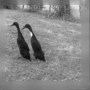

In [11]:
im = Image.fromarray(orig)
im.show()

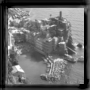

In [10]:
im = Image.fromarray(orig)
im.show()

In [12]:
# verify prediction shapes
with open("../challenge_testset/testset_submission_random.pkl", "rb") as f:
    testset_submission = pickle.load(f)

sum([len(x)!=len(y) for x,y in zip(pred_list, testset_submission)])

0

In [43]:
with open("submission_test.pkl", "wb") as f:
    pickle.dump(pred_list, f)

In [13]:
with open("submission_v4.pkl", "wb") as f:
    pickle.dump(pred_list, f)

In [14]:
pred_list

[array([101,  99,  99, ...,  75,  78,  83], dtype=uint8),
 array([238, 239, 238, ...,  98, 100, 104], dtype=uint8),
 array([ 98,  96,  96, ..., 100, 102, 105], dtype=uint8),
 array([167, 185, 198, ...,  58,  64,  73], dtype=uint8),
 array([ 95,  91,  88, ...,  94,  96, 101], dtype=uint8),
 array([118, 124, 128, ...,  87,  88,  91], dtype=uint8),
 array([100,  98,  98, ..., 114, 115, 115], dtype=uint8),
 array([110, 116, 124, ...,  86,  89,  93], dtype=uint8),
 array([125, 132, 137, ..., 111, 112, 115], dtype=uint8),
 array([182, 181, 179, ..., 120, 115, 112], dtype=uint8),
 array([ 93,  89,  87, ..., 106, 107, 108], dtype=uint8),
 array([ 99,  96,  94, ..., 106, 106, 108], dtype=uint8),
 array([228, 211, 204, ..., 118, 116, 115], dtype=uint8),
 array([ 83,  78,  75, ..., 103, 103, 106], dtype=uint8),
 array([227, 228, 228, ...,  97, 100, 104], dtype=uint8),
 array([209, 210, 209, ..., 104, 105, 107], dtype=uint8),
 array([ 93,  89,  86, ...,  94,  97, 101], dtype=uint8),
 array([103, 1

In [25]:
with open("submission.pkl", "rb") as f:
    a = pickle.load(f)
with open("submission_.pkl", "rb") as f:
    b = pickle.load(f)

In [27]:
sum([np.array_equal(a_,b_) for a_,b_ in zip(a,b)])

208

In [28]:
len(a)

208

In [65]:
n = 100
rng = np.random.default_rng(seed=0)
borders_a = rng.integers(5, 10, (n,))
borders_b = rng.integers(5, (15 - borders_a), (n,))
edge = np.zeros((2,n), dtype=int)
edge[rng.choice([0, 1], size=(n,)), np.arange(n)] = 1
borders = np.stack([borders_a, borders_b])[edge, np.arange(n)]
borders = list(map(tuple, borders.T))

In [66]:
borders[0]

(9, 5)

In [70]:
raise Exception("dff")

Exception: dff

In [64]:
np.full((2,n), 9)

array([[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [29]:
90-14

76

In [16]:
with open("../challenge_testset/testset.pkl", "rb") as f:
    testset_submission = pickle.load(f)

In [17]:
testset_submission.keys()

dict_keys(['input_arrays', 'known_arrays', 'borders_x', 'borders_y', 'sample_ids'])

In [43]:
testset_submission["known_arrays"][0][10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0], dtype=uint8)

In [44]:
testset_submission["borders_y"][0]

array([9, 5])

In [77]:
np.stack(testset_submission["borders_y"])[:,1].max()

9